This file contains the EDA performed on the dataset prior to continuing with the transition matrix and simulation. It has been prepared in a Jupyter notebook instead of a simple Python file to enable ease of viewing charts. The objective was to prepare a summary of the data collected which was accessible by non-data scientists, focusing on the total number of customers in each department and the time they spent in the store.

In [12]:
import pandas as pd
import datetime
import seaborn as sns
import os

sns.set(rc = {"figure.figsize": (12, 8)})

In [13]:
def data_input (files, file_type = ".csv"):
    """
    Implements automatization for loading the csv files into dataframes and combines all of them into a single df.
    
    Args:
    files (list): a list of all files present in this directory
    file_type (str, default value): the file 
    
    Return:
    df (dataframe): a concated df of all daily data
    """

    all_df = []

    for file in files:
        if file.endswith(file_type):
            day = pd.read_csv(path + file, sep = ";")
            day["timestamp"] = pd.to_datetime(day["timestamp"])
            day["day"] = file[:-4]
            day["customer_no"] = day["day"] + day["customer_no"].astype(str)

            # binning by hour
            bins = range(7, 23, 1)
            labels = ("07:00-08:00", "08:00-09:00", "09:00-10:00", "10:00-11:00", "11:00-12:00", "12:00-13:00", "13:00-14:00", "14:00-15:00", "15:00-16:00", "16:00-17:00", "17:00-18:00", "18:00-19:00", "19:00-20:00", "20:00-21:00", "21:00-22:00")
            day["hour"] = pd.cut(day.timestamp.dt.hour, bins, labels = labels, right = False) 

            all_df.append(day)
    
    df = pd.concat(all_df, axis=0, ignore_index=True)

    return df

path = "./data/"
files = os.listdir(path = path)

df = data_input(files)

In [14]:
# Checking for NaNs
print(df.isna().sum())

timestamp      0
customer_no    0
location       0
day            0
hour           0
dtype: int64


In [15]:
# Checking for customers that didn't go to checkout
df_checkout = df[df["location"] == "checkout"]
df_checkout = df_checkout.groupby(["customer_no"], as_index = False).count()
df_customers = df.groupby(["customer_no"], as_index = False).count()

print(df_customers.count()-df_checkout.count())

customer_no    28
timestamp      28
location       28
day            28
hour           28
dtype: int64


In [16]:
# Removing the customers who did not go to checkout
dif_list = [x for x in list(df_customers["customer_no"].unique()) if x not in list(df_checkout["customer_no"].unique())]
df = df[~df["customer_no"].isin(dif_list)]

Text(0.5, 0, '')

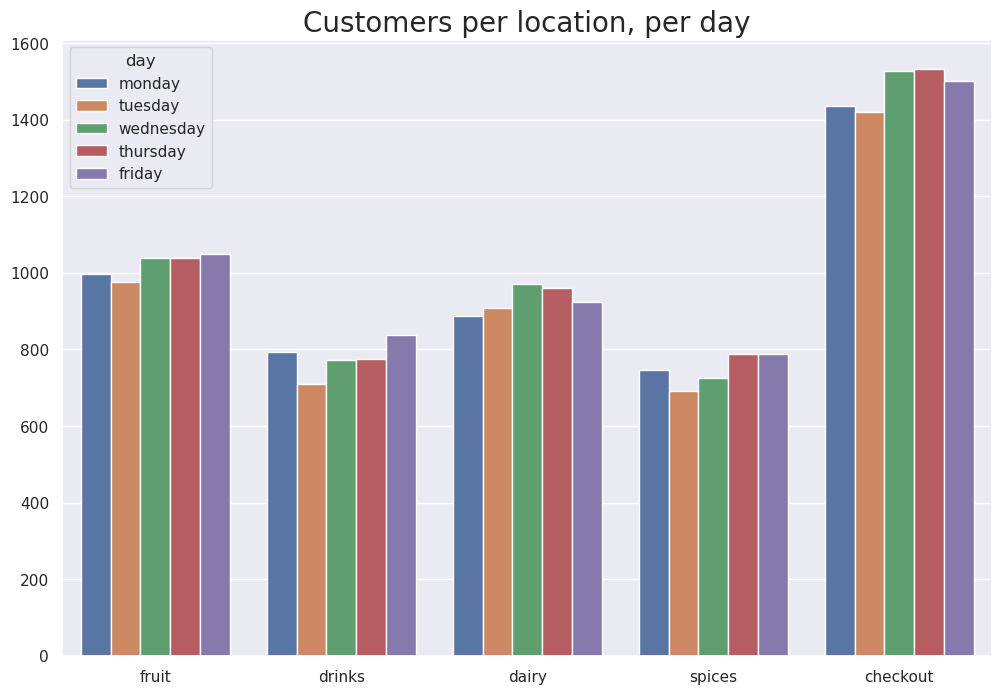

In [17]:
# Visualizing the number of customers in each department per day
hue_order = ["monday", "tuesday", "wednesday", "thursday", "friday"]
chart = sns.countplot(x = "location", data = df, hue = df["day"], hue_order = hue_order)
chart.axes.set_title("Customers per location, per day", fontsize = 20)
chart.set_ylabel("")
chart.set_xlabel("")

Text(0.5, 54.249999999999986, '')

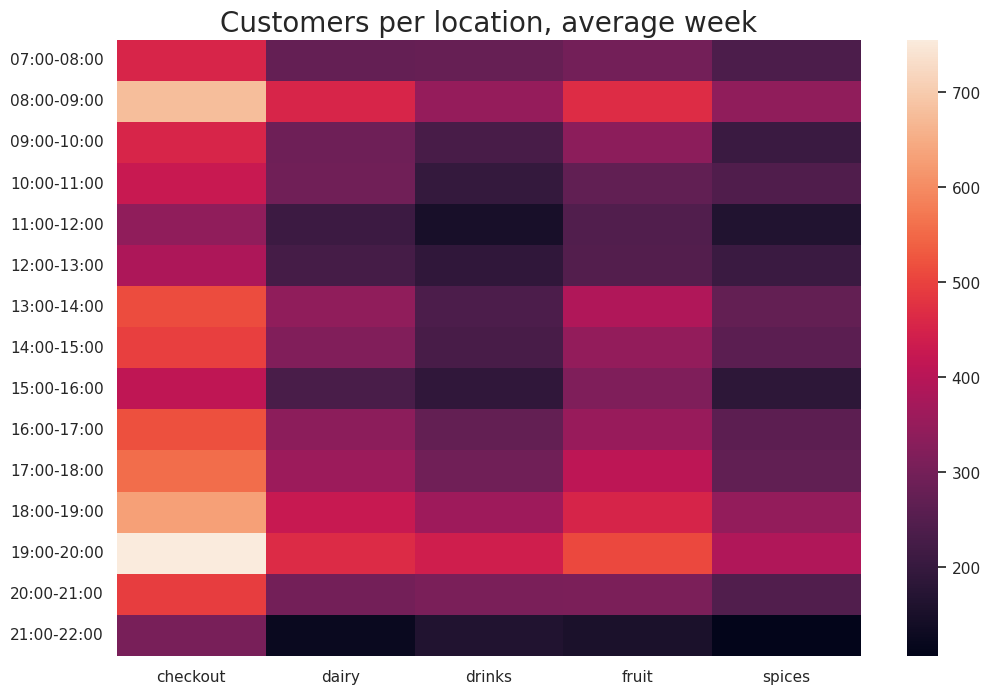

In [18]:
# Visualizing customer distribution in different departments by hour for all days
df_grouped = df.groupby(by = ["location", "hour"])[["customer_no"]].count().rename({"customer_no": "count"}, axis = 1)
df_grouped = df_grouped.reset_index()
df_pivot = df_grouped.pivot(index = "hour", columns = "location", values = "count")

chart = sns.heatmap(df_pivot)
chart.axes.set_title("Customers per location, average week", fontsize = 20)
chart.set_ylabel("")
chart.set_xlabel("")

Text(0.5, 0, '')

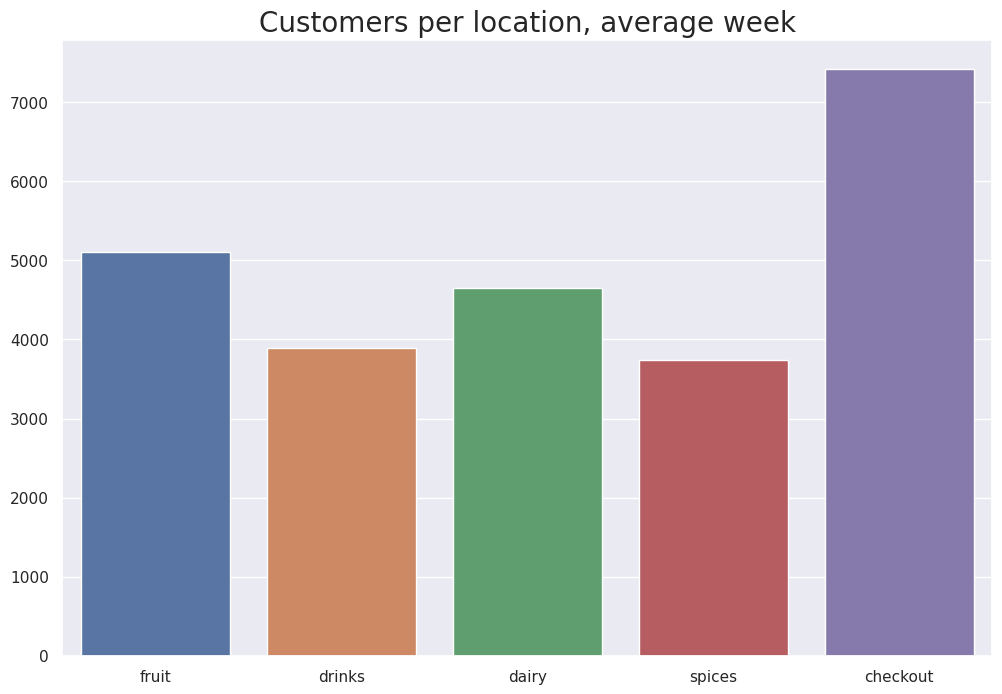

In [19]:
# Visualizing the number of customers in each department for all days
chart = sns.countplot(x = "location", data = df)
chart.axes.set_title("Customers per location, average week", fontsize = 20)
chart.set_ylabel("")
chart.set_xlabel("")

/tmp/ipykernel_11438/3792620275.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)


[Text(0, 0, '07:00-08:00'),
 Text(1, 0, '08:00-09:00'),
 Text(2, 0, '09:00-10:00'),
 Text(3, 0, '10:00-11:00'),
 Text(4, 0, '11:00-12:00'),
 Text(5, 0, '12:00-13:00'),
 Text(6, 0, '13:00-14:00'),
 Text(7, 0, '14:00-15:00'),
 Text(8, 0, '15:00-16:00'),
 Text(9, 0, '16:00-17:00'),
 Text(10, 0, '17:00-18:00'),
 Text(11, 0, '18:00-19:00'),
 Text(12, 0, '19:00-20:00'),
 Text(13, 0, '20:00-21:00'),
 Text(14, 0, '21:00-22:00')]

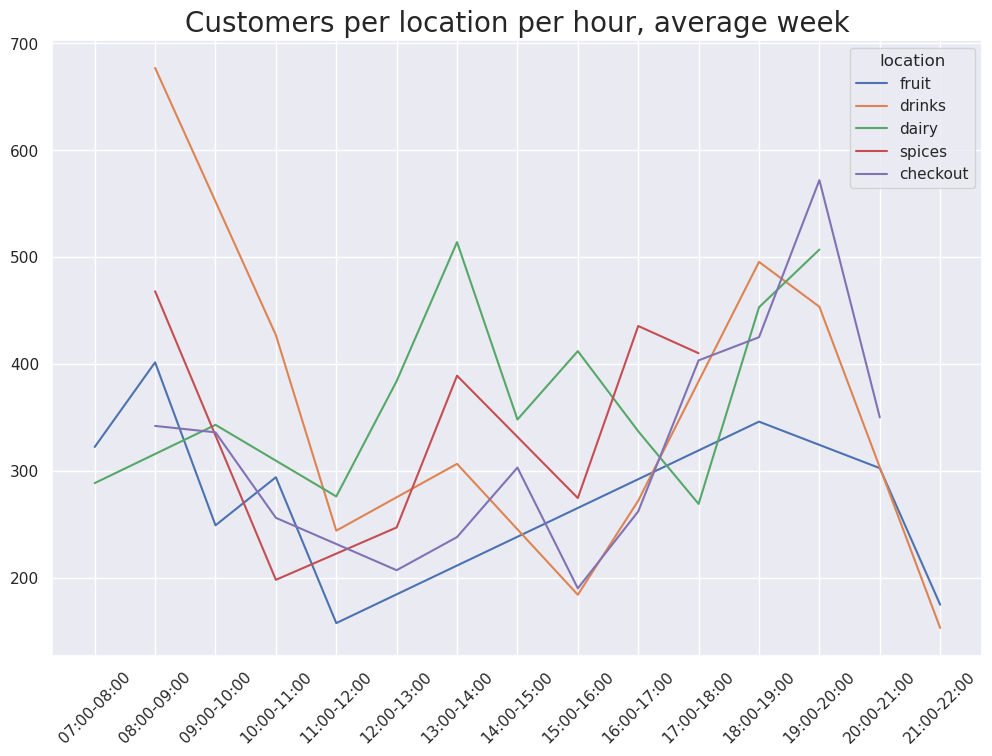

In [20]:
# Visualizing customer distribution in different departments by hour for all days
chart = sns.lineplot(data = df_grouped, x = "hour", y = "count", hue = df["location"], errorbar = None)
chart.axes.set_title("Customers per location per hour, average week", fontsize = 20)
chart.set_ylabel("")
chart.set_xlabel("")
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45)

Text(0.5, 0, 'Minutes')

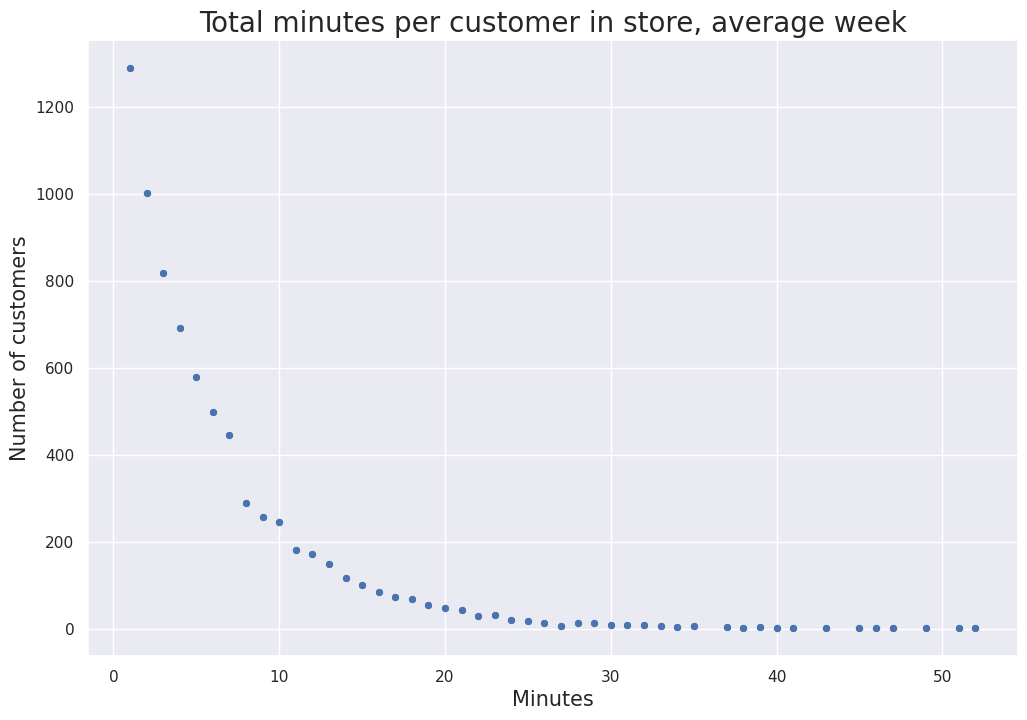

In [21]:
# Visualizing the total time each customer spent in the market
first_last = df.sort_values("timestamp")
last_df = first_last.drop_duplicates(["customer_no"], keep = "last").set_index("customer_no")
first_df = first_last.drop_duplicates(["customer_no"], keep = "first").set_index("customer_no")

first_last = pd.concat([last_df["timestamp"], first_df["timestamp"]],keys = ("last", "first"), axis = 1)
first_last["duration"] = first_last["last"] - first_last["first"]
first_last = first_last.reset_index()
first_last = first_last.groupby(by = ["duration"])[["customer_no"]].count().rename({"customer_no": "count"}, axis = 1)
first_last = first_last.reset_index()
first_last["minutes"] = first_last["duration"].dt.total_seconds() / 60

minutes_in_store = sns.scatterplot(data = first_last, x = "minutes", y = "count")
minutes_in_store.axes.set_title("Total minutes per customer in store, average week", fontsize = 20)
minutes_in_store.set_ylabel("Number of customers", fontsize = 15)
minutes_in_store.set_xlabel("Minutes", fontsize = 15)

In [22]:
df.to_csv("./output/df.csv")